Found 1067 files belonging to 5 classes.


2025-07-08 02:43:33.860322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


✅ 总体准确率: 97.28%

📊 每一类的误分类统计：
- 类别【Pallas cats】全部识别正确
- 类别【Persian cats】被误判为：{'Ragdoll cats': 11, 'Singapura cats': 1, 'Sphynx cats': 1}
- 类别【Ragdoll cats】被误判为：{'Pallas cats': 1, 'Persian cats': 10, 'Singapura cats': 1}
- 类别【Singapura cats】被误判为：{'Persian cats': 1, 'Ragdoll cats': 1, 'Sphynx cats': 2}
- 类别【Sphynx cats】全部识别正确


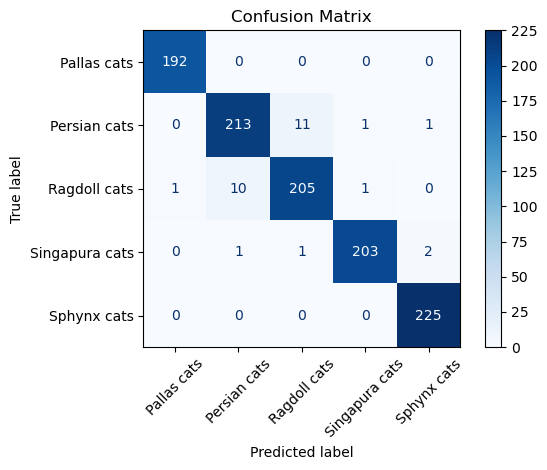

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.layers import DepthwiseConv2D
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
import shutil

# ---------- 配置 ----------
IMG_SIZE = 300
BATCH_SIZE = 32
MODEL_PATH = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/classify/finetuned_model(final).h5'
TEST_DIR = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/mix_dataset/test'
WRONG_SAVE_DIR = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/wrong_samples'  # 错误分类图片保存路径

# ---------- 兼容 DepthwiseConv2DCompat ----------
class DepthwiseConv2DCompat(DepthwiseConv2D):
    def __init__(self, *args, groups=1, **kwargs):
        super().__init__(*args, **kwargs)

# ---------- 数据集加载 ----------
def load_test_dataset(with_path=False):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        label_mode='int',
        shuffle=False
    )
    class_names = ds.class_names
    file_paths = ds.file_paths if hasattr(ds, 'file_paths') else [str(p) for p in Path(TEST_DIR).rglob("*.jpg")]

    def _process(x, y):
        x = tf.cast(x, tf.float32)
        x = preprocess_input(x)
        return x, y

    ds_proc = ds.map(_process)
    return ds_proc, class_names, file_paths

# ---------- 验证并保存错误分类 ----------
def validate():
    ds, class_names, file_paths = load_test_dataset()
    y_true, y_pred = [], []

    with custom_object_scope({'DepthwiseConv2DCompat': DepthwiseConv2DCompat}):
        model = load_model(MODEL_PATH, compile=False)

    Path(WRONG_SAVE_DIR).mkdir(parents=True, exist_ok=True)

    for idx, (x_batch, y_batch) in enumerate(ds):
        preds = model.predict(x_batch, verbose=0)
        pred_label = np.argmax(preds[0])
        true_label = int(y_batch.numpy()[0])

        y_true.append(true_label)
        y_pred.append(pred_label)

        if pred_label != true_label:
            src_path = file_paths[idx]
            true_class = class_names[true_label]
            wrong_dir = Path(WRONG_SAVE_DIR) / true_class
            wrong_dir.mkdir(parents=True, exist_ok=True)
            dst_path = wrong_dir / Path(src_path).name
            shutil.copy(src_path, dst_path)

    # 准确率 + 混淆统计
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = np.mean(y_true == y_pred)
    print(f"✅ 总体准确率: {acc:.2%}")

    cm = confusion_matrix(y_true, y_pred)
    print("\n📊 每一类的误分类统计：")
    for i, cname in enumerate(class_names):
        errors = {}
        for j, count in enumerate(cm[i]):
            if i != j and count > 0:
                errors[class_names[j]] = count
        if errors:
            print(f"- 类别【{cname}】被误判为：{errors}")
        else:
            print(f"- 类别【{cname}】全部识别正确")

    # 混淆矩阵图
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    validate()
